In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'IFF'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,774,-434,340,107,405,563,556,1713,675,...,207,0,10,517,934,1837,164,-38,81.5,2014-11-04
1,2014-12-31,756,-428,328,90,479,494,569,1711,675,...,216,0,8,518,934,1976,201,-45,81.5,2015-03-01
2,2015-03-31,775,-429,346,128,444,525,536,1754,675,...,216,0,8,487,935,1940,32,-19,80.9,2015-05-05
3,2015-06-30,768,-423,345,105,377,566,562,1722,753,...,242,0,9,525,989,2031,135,-19,80.9,2015-08-04
4,2015-09-30,765,-418,347,106,272,570,589,1639,932,...,254,0,133,687,1058,2320,128,-29,80.9,2015-11-04


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-11-04,255.0,2820,-1896,924,27,629,1831,2549,...,8381,33395,1112,0,1142,3420,9159,16417,420,-100
37,2023-12-31,2024-02-29,255.0,2703,-1843,860,-2609,709,1726,2477,...,8357,30978,1378,0,885,3758,9186,16336,644,-113
38,2024-03-31,2024-05-06,256.0,2899,-1875,1024,61,732,1977,2411,...,8116,30642,1346,0,312,3820,9150,16316,99,-118
39,2024-06-30,2024-08-05,256.0,2889,-1821,1068,170,671,1775,2160,...,6881,29543,1272,0,783,3425,8596,15289,237,-82
40,2024-09-30,2024-11-04,257.0,2925,-1873,1052,60,567,1772,2200,...,6770,29928,1211,0,468,3218,8631,15118,366,-103


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-04,255.0,2820,-1896,924,27,629,1831,2549,...,33395,1112,0,1142,3420,9159,16417,420,-100,1
37,2023-12-31,2024-02-29,255.0,2703,-1843,860,-2609,709,1726,2477,...,30978,1378,0,885,3758,9186,16336,644,-113,1
38,2024-03-31,2024-05-06,256.0,2899,-1875,1024,61,732,1977,2411,...,30642,1346,0,312,3820,9150,16316,99,-118,1
39,2024-06-30,2024-08-05,256.0,2889,-1821,1068,170,671,1775,2160,...,29543,1272,0,783,3425,8596,15289,237,-82,1
40,2024-09-30,2024-11-04,257.0,2925,-1873,1052,60,567,1772,2200,...,29928,1211,0,468,3218,8631,15118,366,-103,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-04,255.0,2820.0,-1896.0,924.0,27.0,629.0,1831.0,2549.0,...,33395.0,1112.0,0.0,1142.0,3420.0,9159.0,16417.0,420.0,-100.0,1
37,2023-12-31,2024-02-29,255.0,2703.0,-1843.0,860.0,-2609.0,709.0,1726.0,2477.0,...,30978.0,1378.0,0.0,885.0,3758.0,9186.0,16336.0,644.0,-113.0,1
38,2024-03-31,2024-05-06,256.0,2899.0,-1875.0,1024.0,61.0,732.0,1977.0,2411.0,...,30642.0,1346.0,0.0,312.0,3820.0,9150.0,16316.0,99.0,-118.0,1
39,2024-06-30,2024-08-05,256.0,2889.0,-1821.0,1068.0,170.0,671.0,1775.0,2160.0,...,29543.0,1272.0,0.0,783.0,3425.0,8596.0,15289.0,237.0,-82.0,1
40,2024-09-30,2024-11-04,257.0,2925.0,-1873.0,1052.0,60.0,567.0,1772.0,2200.0,...,29928.0,1211.0,0.0,468.0,3218.0,8631.0,15118.0,366.0,-103.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,76.985283,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.471671,0.528329,0.0,0.0,0.0,0.0,0.439276,0.138243,0.0,0.0
1,2014-11-17,78.554146,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.471671,0.528329,0.0,0.0,0.0,0.0,0.439276,0.138243,0.0,0.0
2,2014-11-24,79.362122,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.471671,0.528329,0.0,0.0,0.0,0.0,0.439276,0.138243,0.0,0.0
3,2014-12-01,81.127129,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.471671,0.528329,0.0,0.0,0.0,0.0,0.439276,0.138243,0.0,0.0
4,2014-12-08,78.499252,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.471671,0.528329,0.0,0.0,0.0,0.0,0.439276,0.138243,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,76.985283,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.0,0.439276,0.138243,0.0,0.0,inf,3.825793,inf,inf,inf
1,2014-11-17,78.554146,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.0,0.439276,0.138243,0.0,0.0,inf,3.903758,inf,inf,inf
2,2014-11-24,79.362122,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.0,0.439276,0.138243,0.0,0.0,inf,3.943910,inf,inf,inf
3,2014-12-01,81.127129,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.0,0.439276,0.138243,0.0,0.0,inf,4.031623,inf,inf,inf
4,2014-12-08,78.499252,2014-09-30,774.0,0.0,20.122699,81.5,0.0,0.0,405.0,...,0.0,0.439276,0.138243,0.0,0.0,inf,3.901030,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

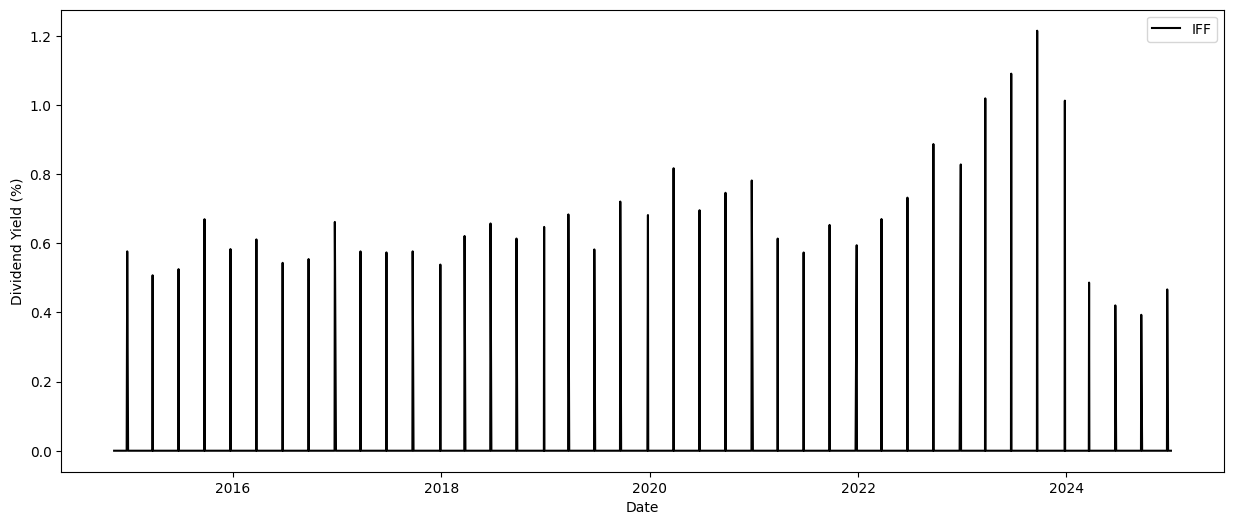

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


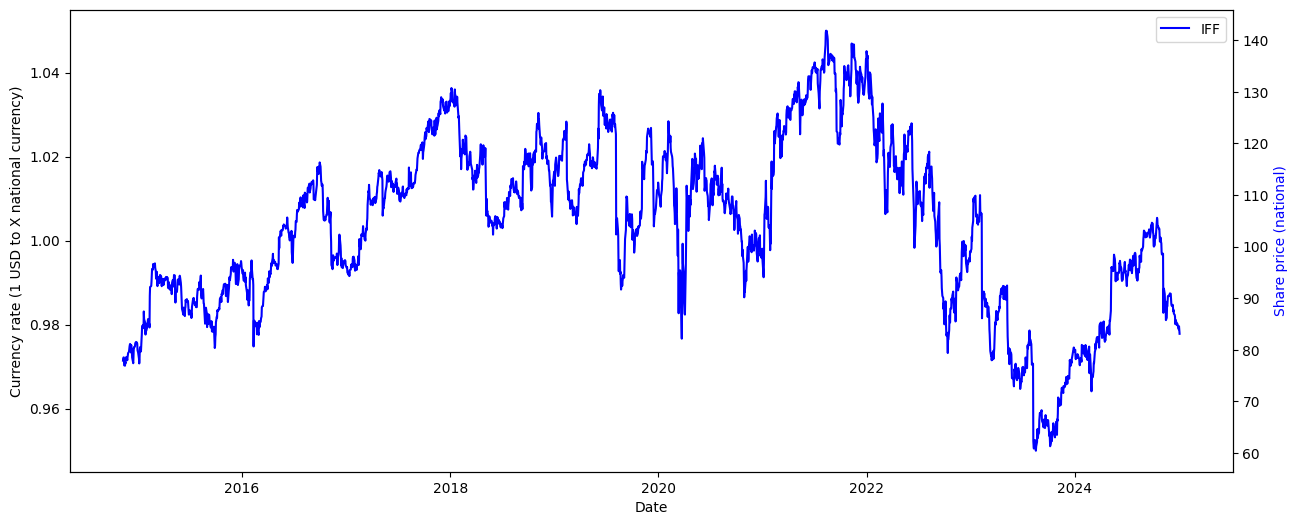

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

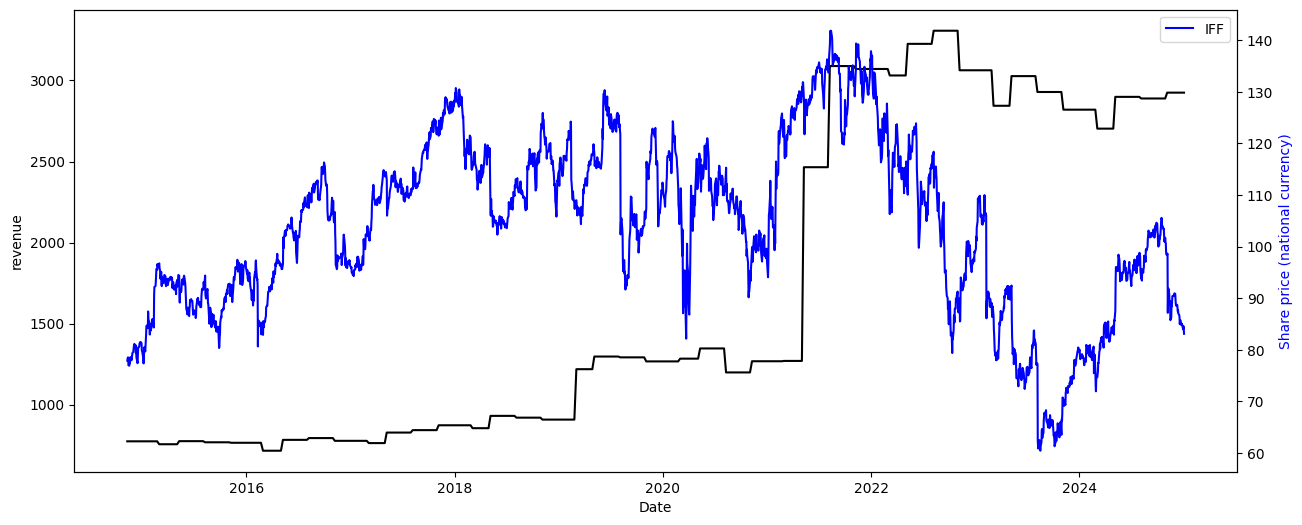

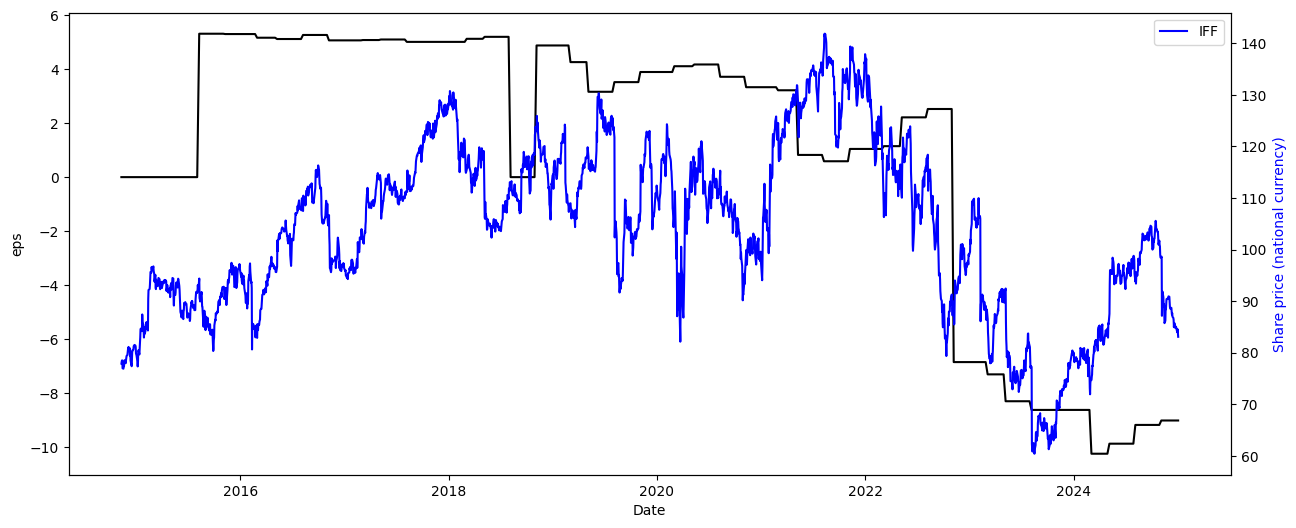

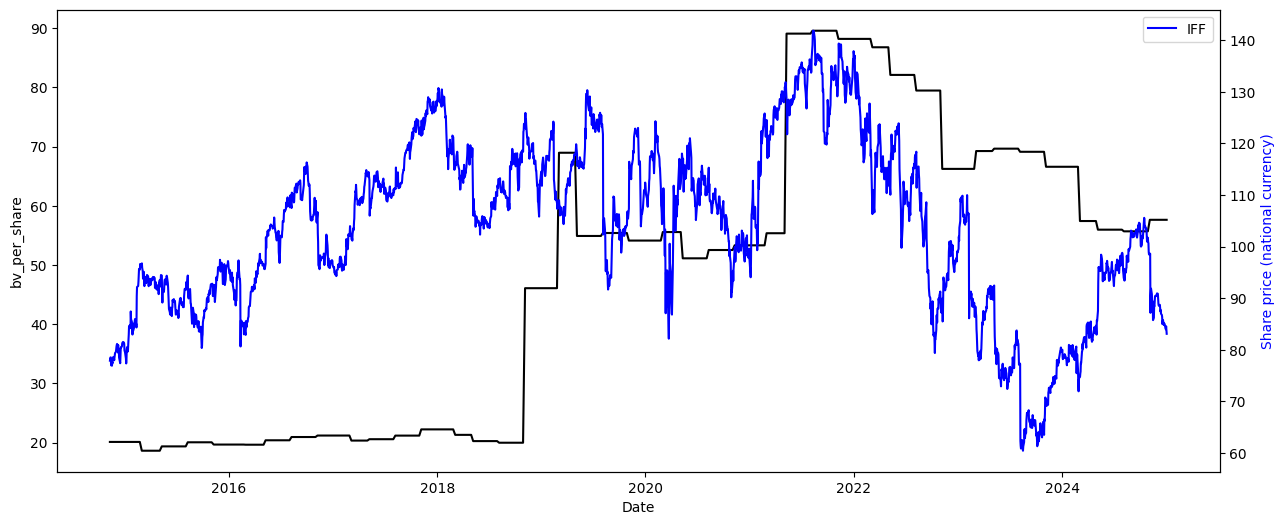

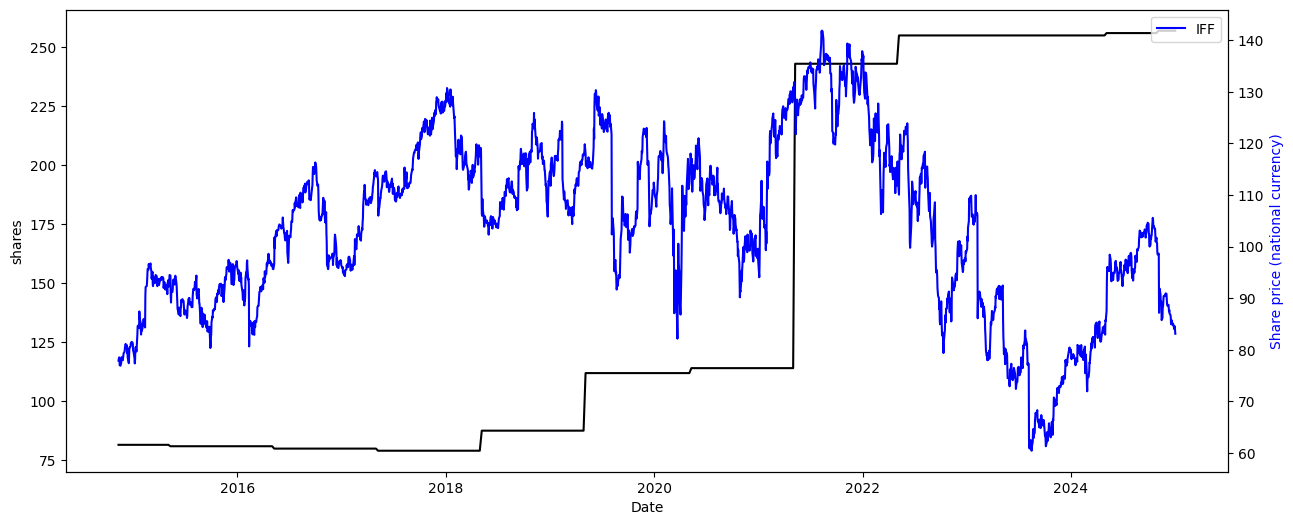

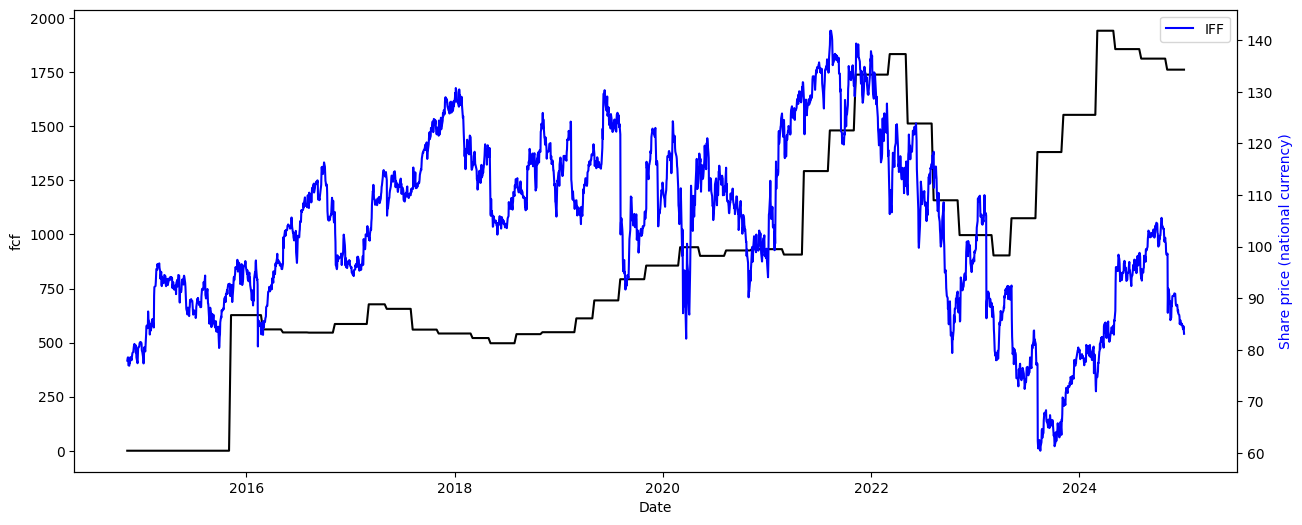

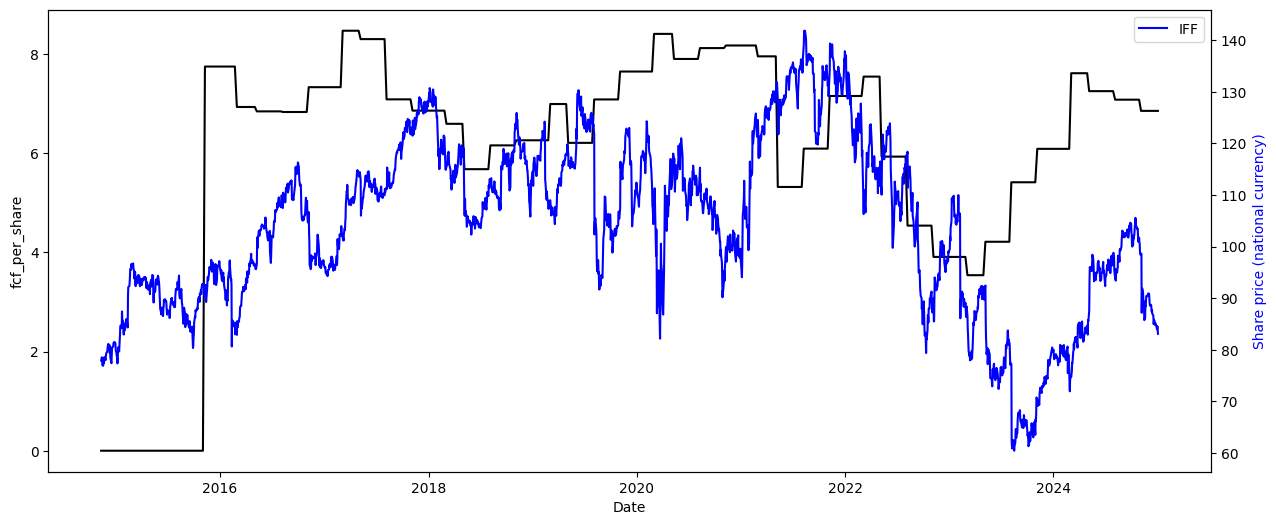

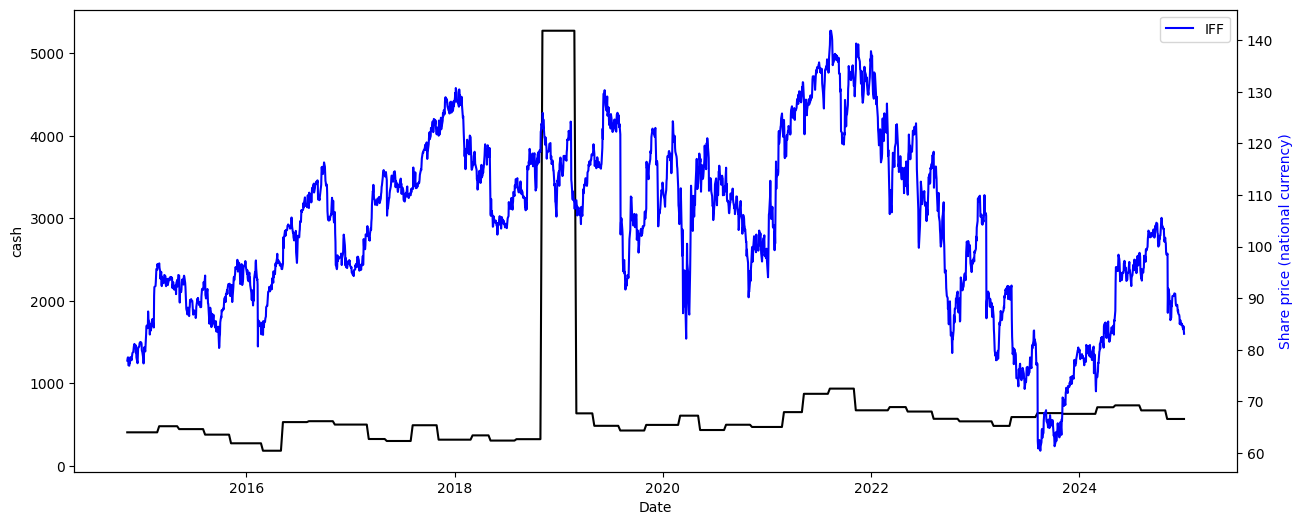

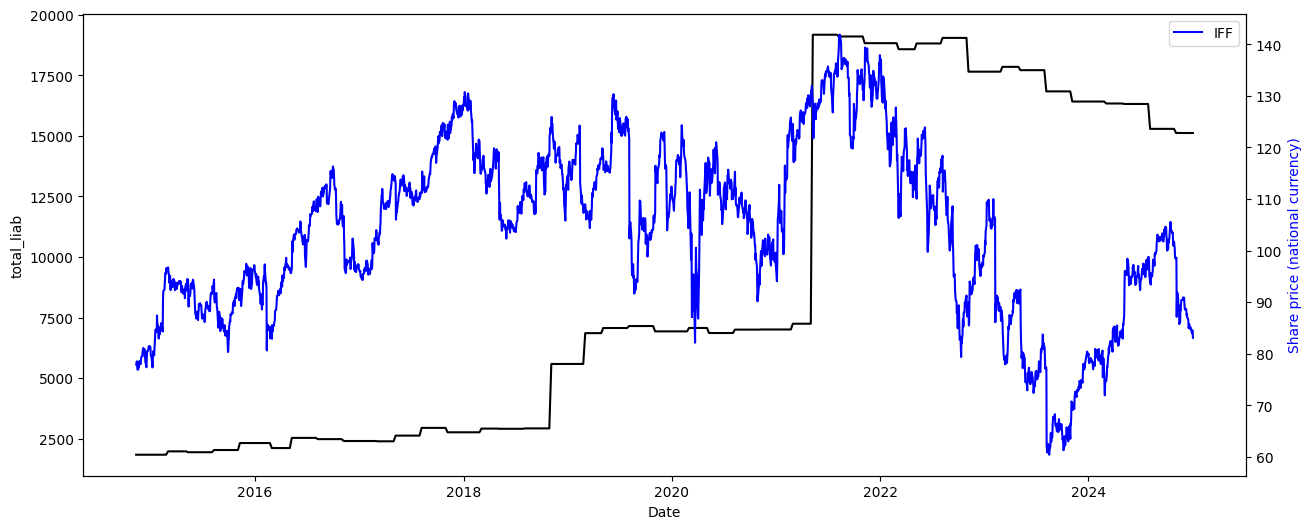

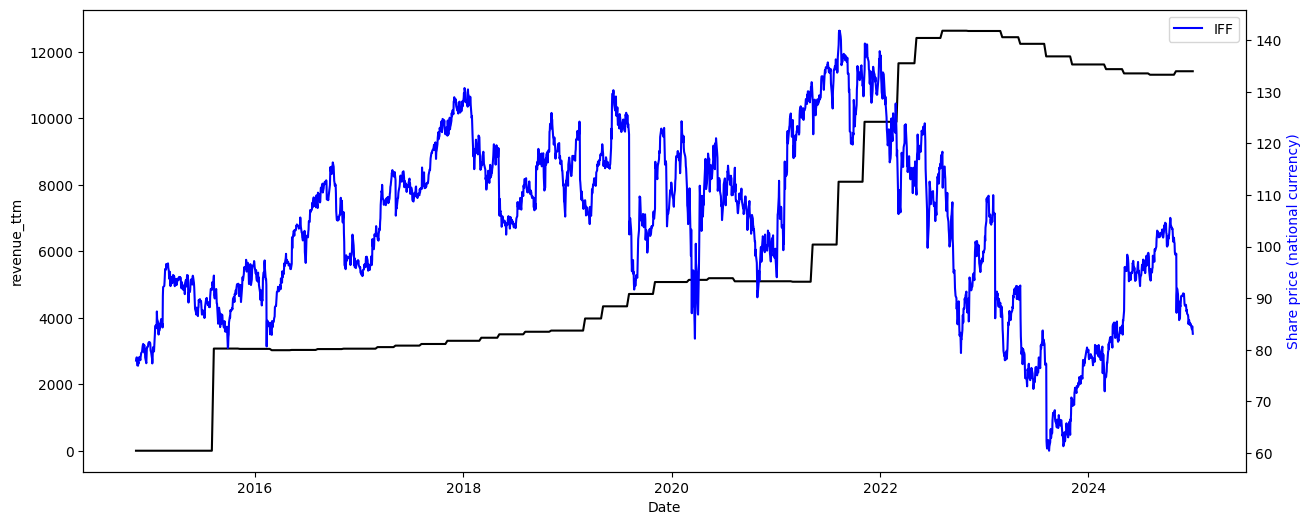

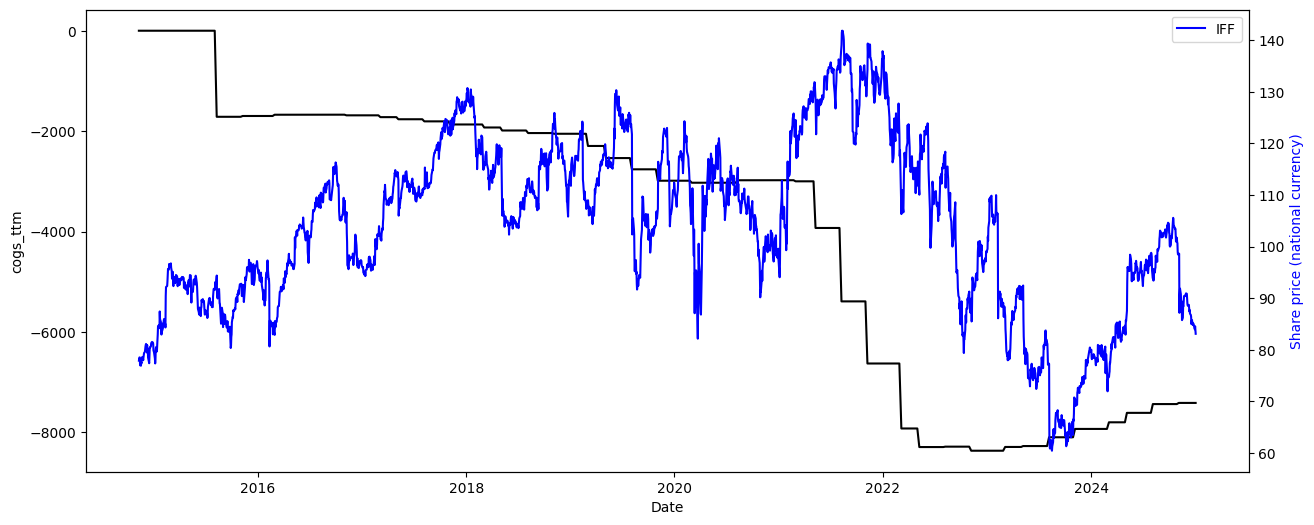

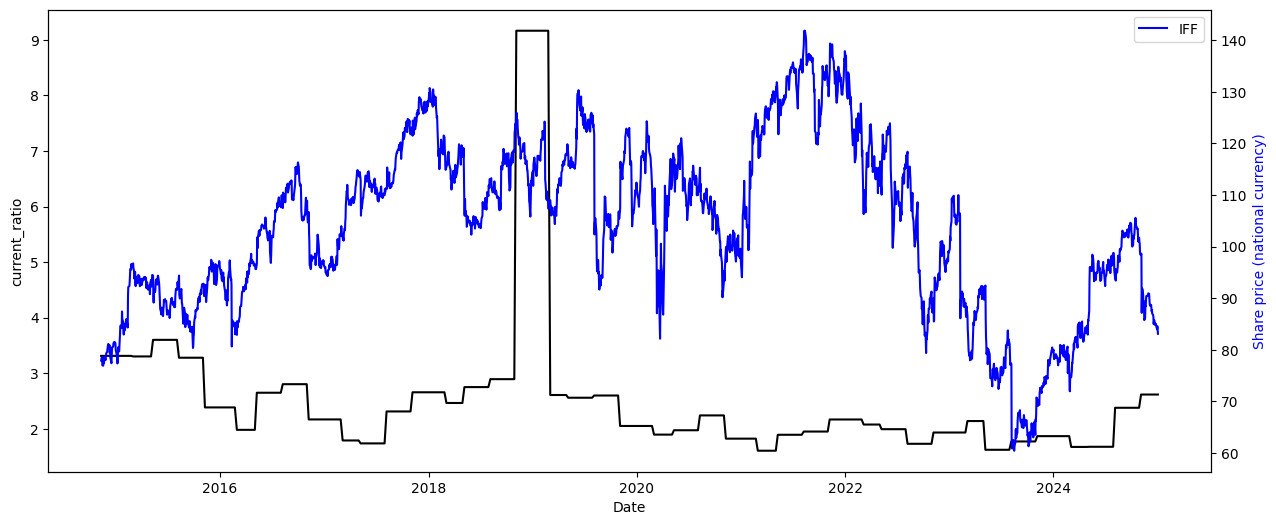

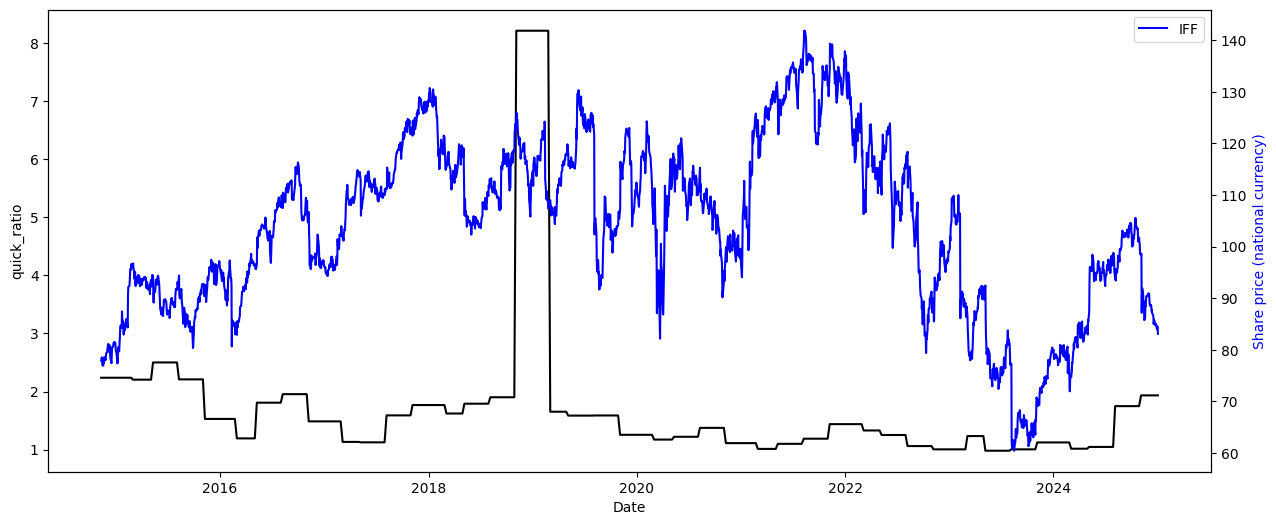

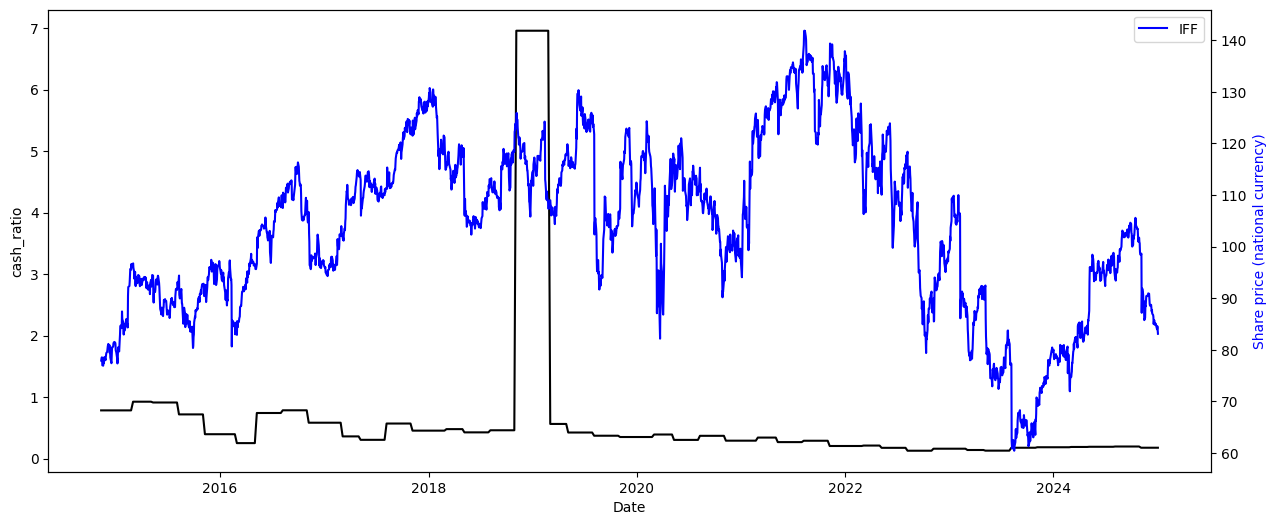

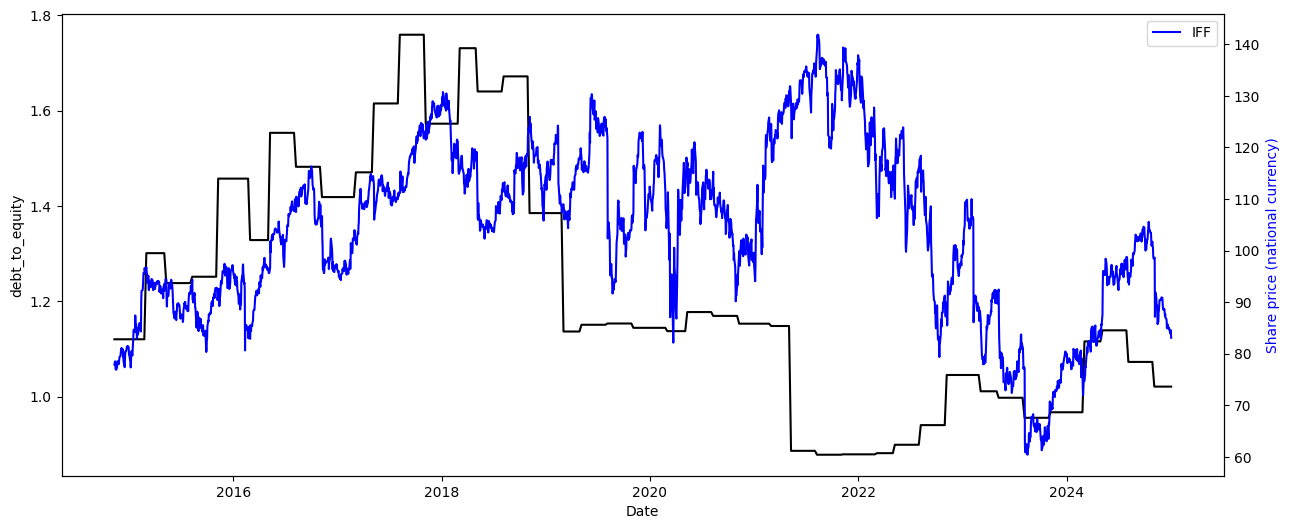

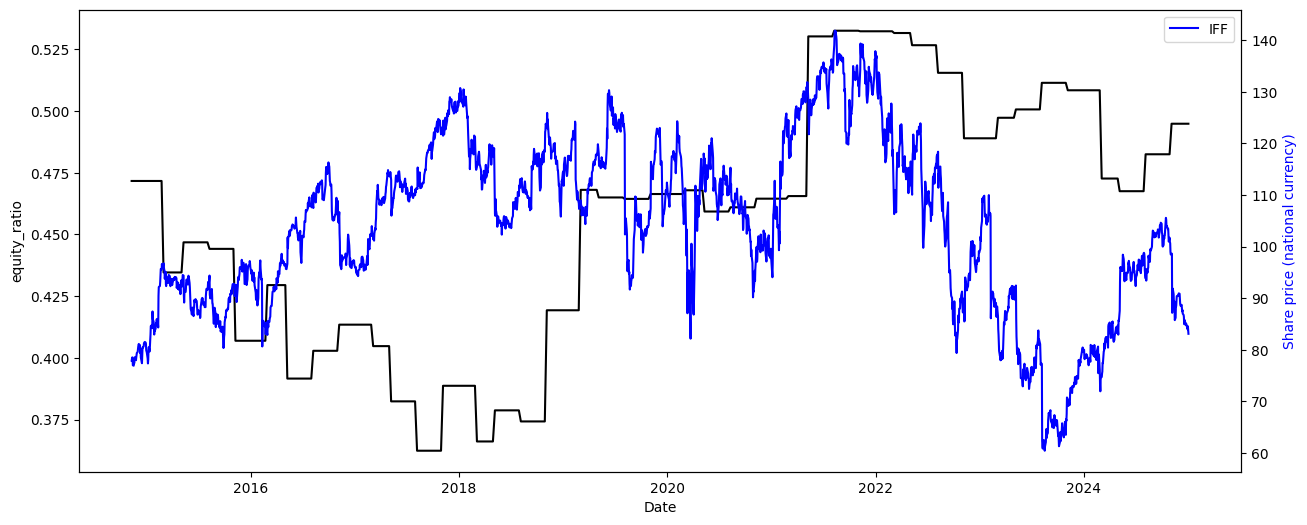

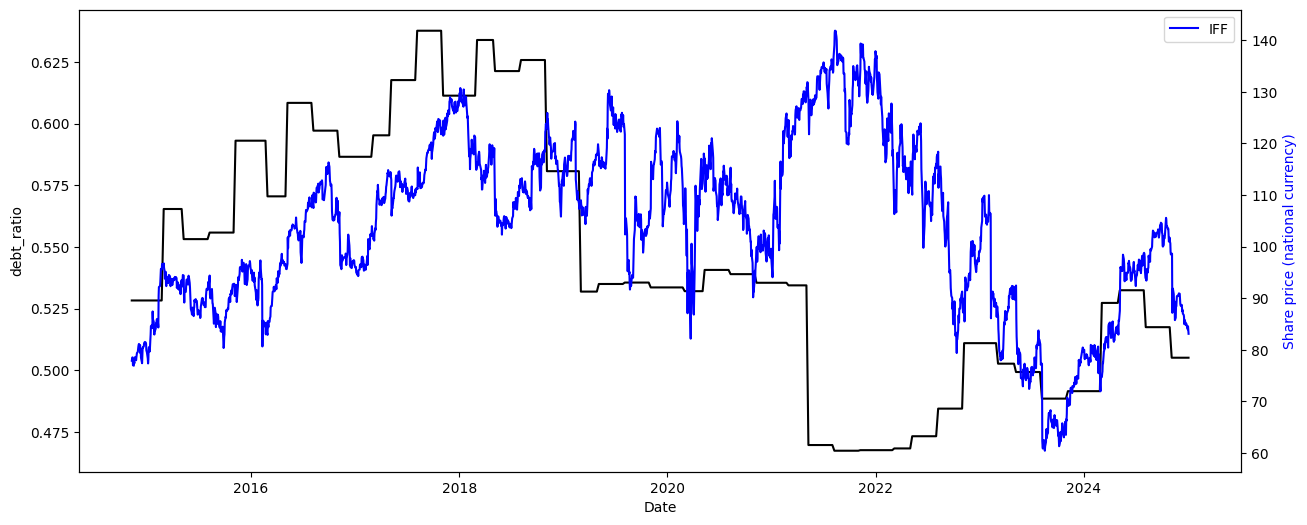

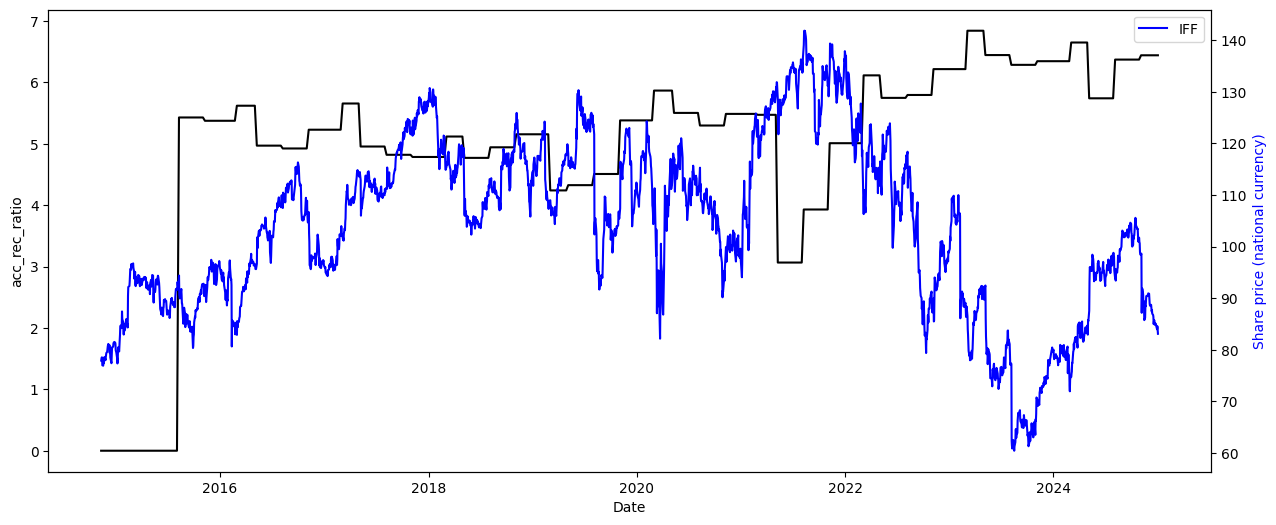

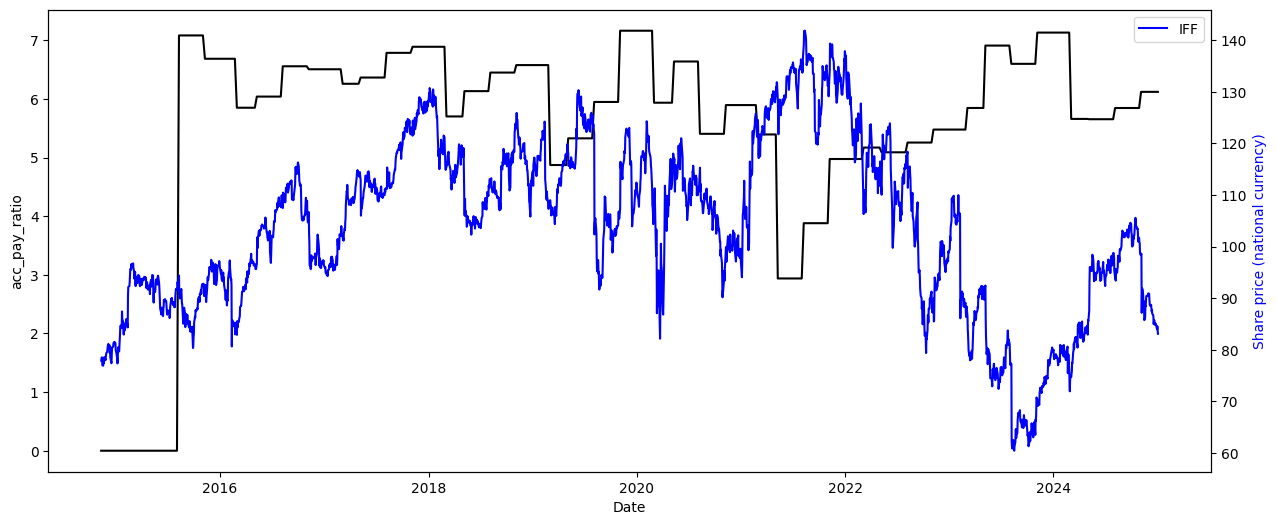

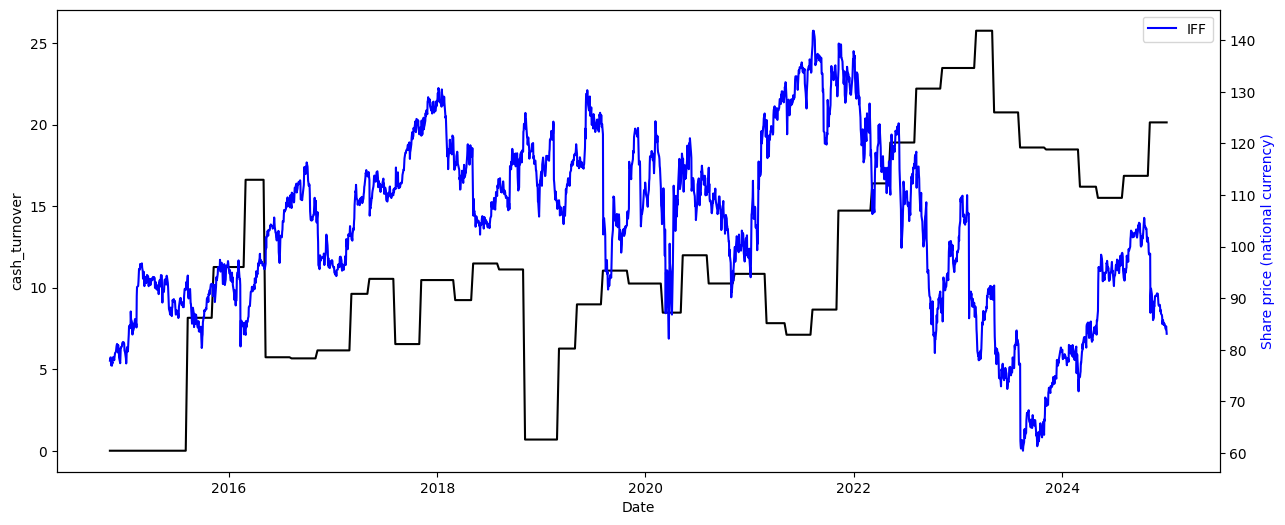

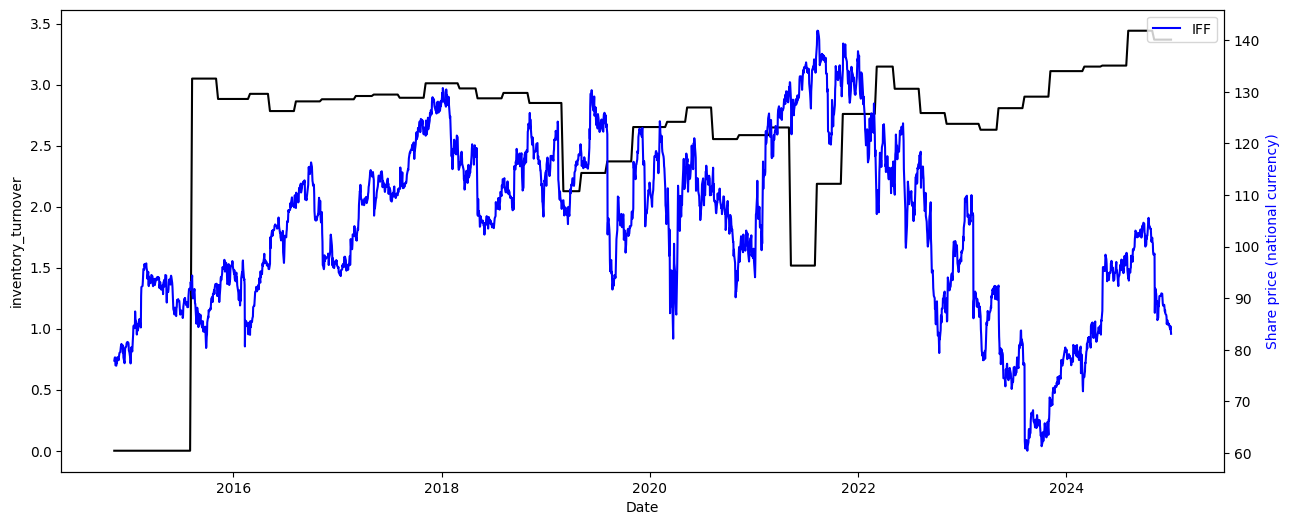

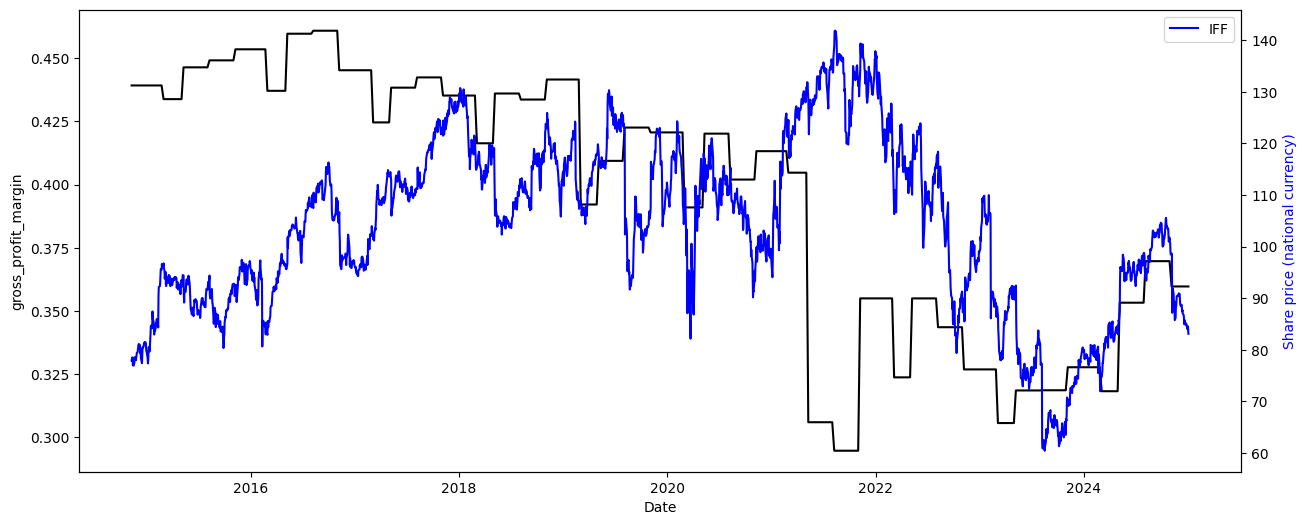

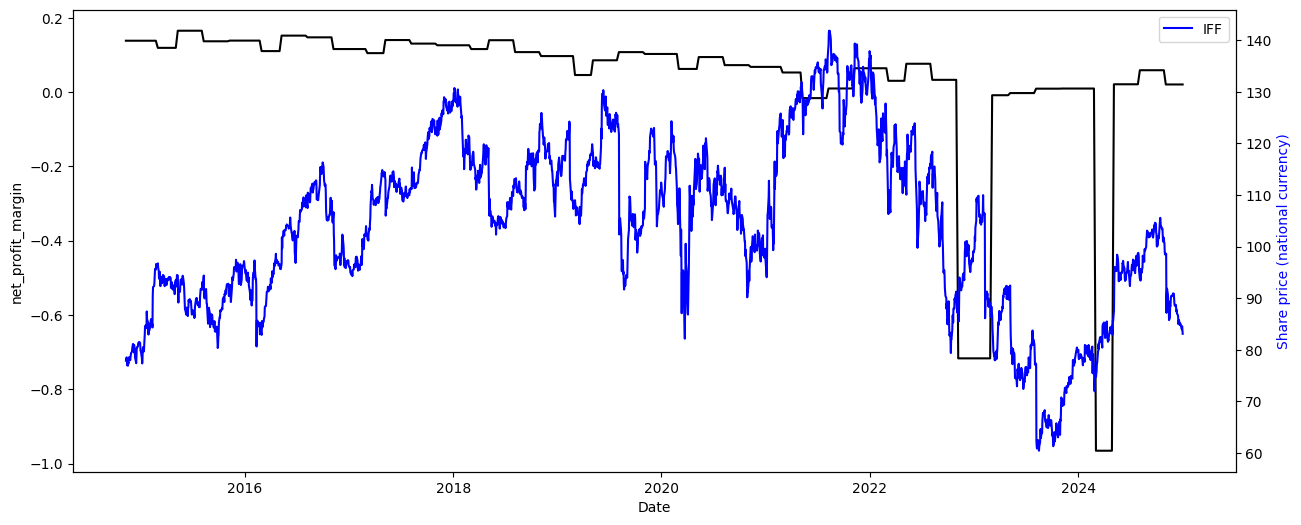

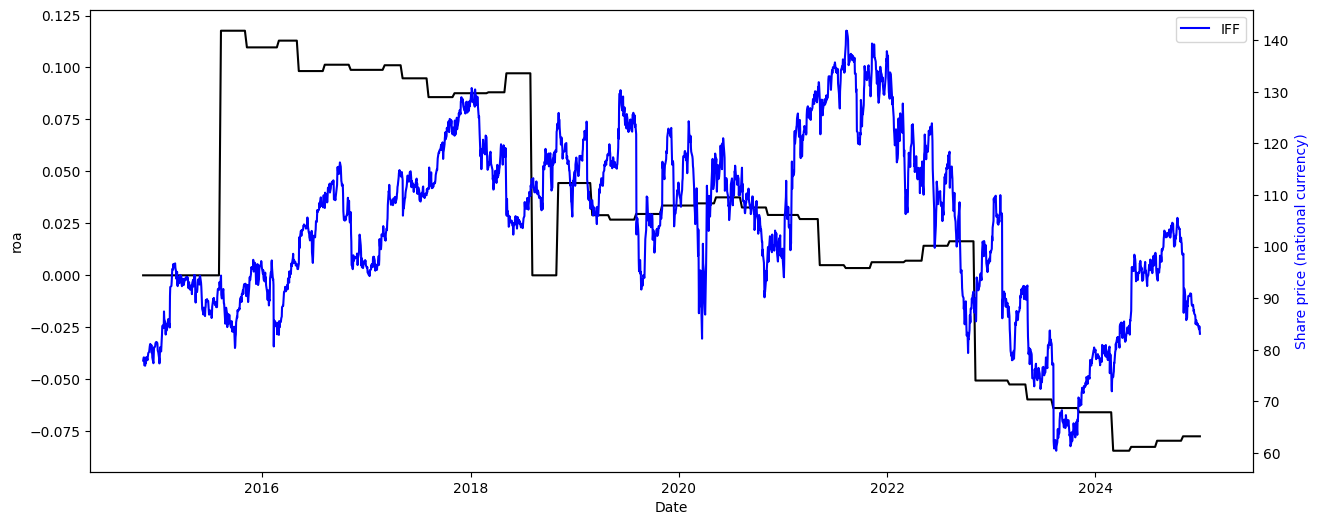

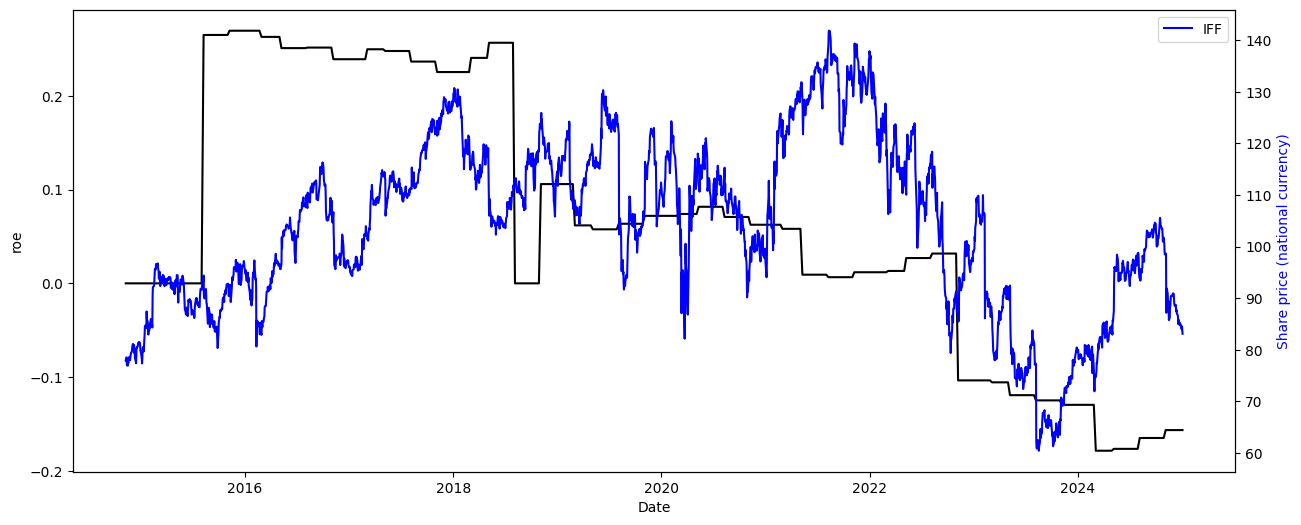

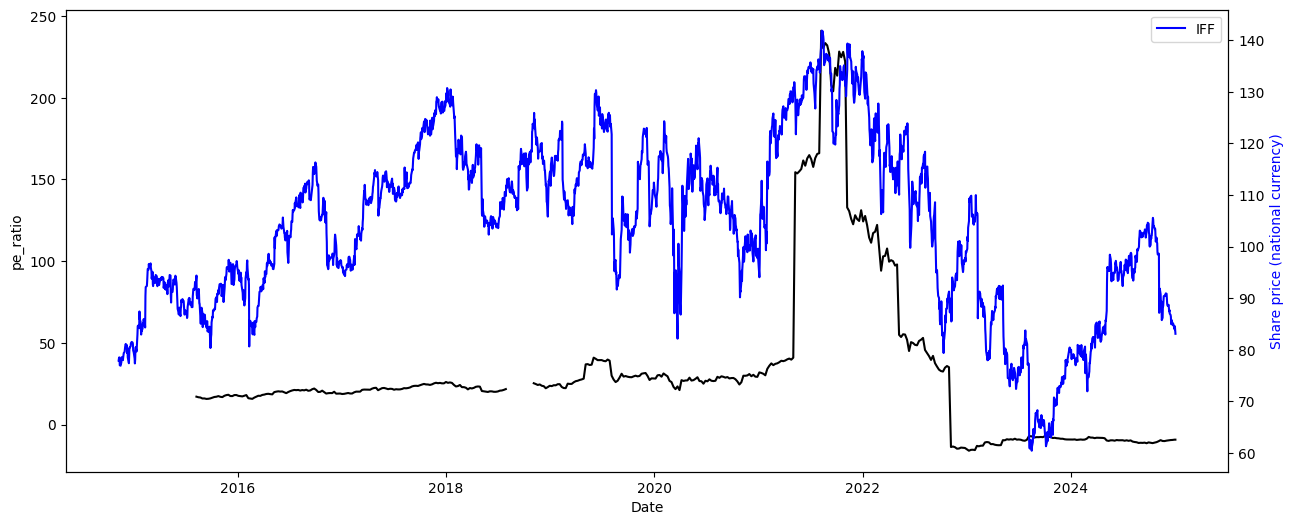

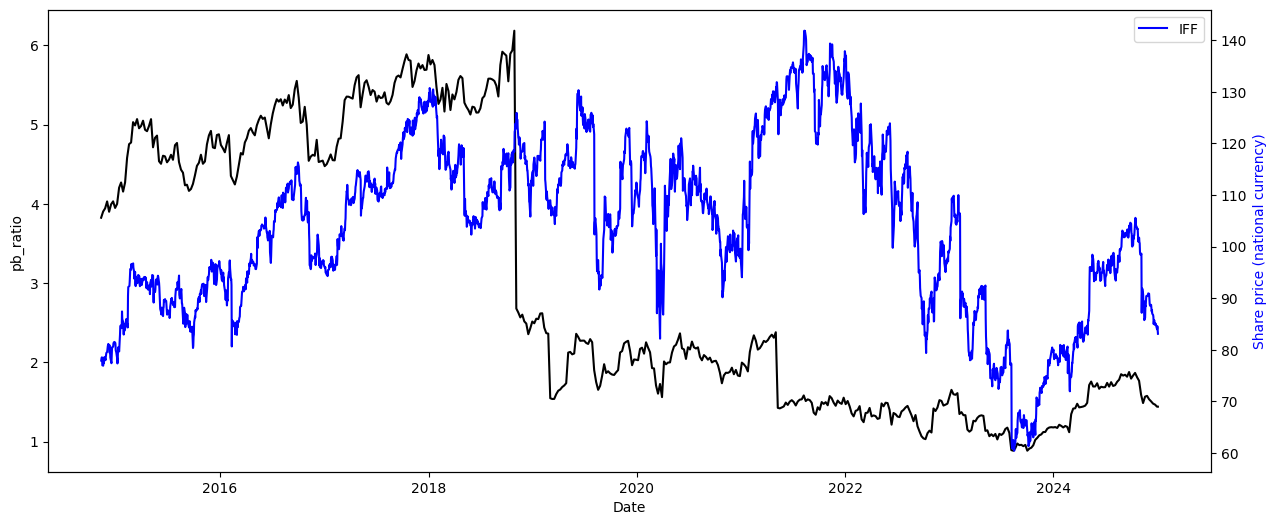

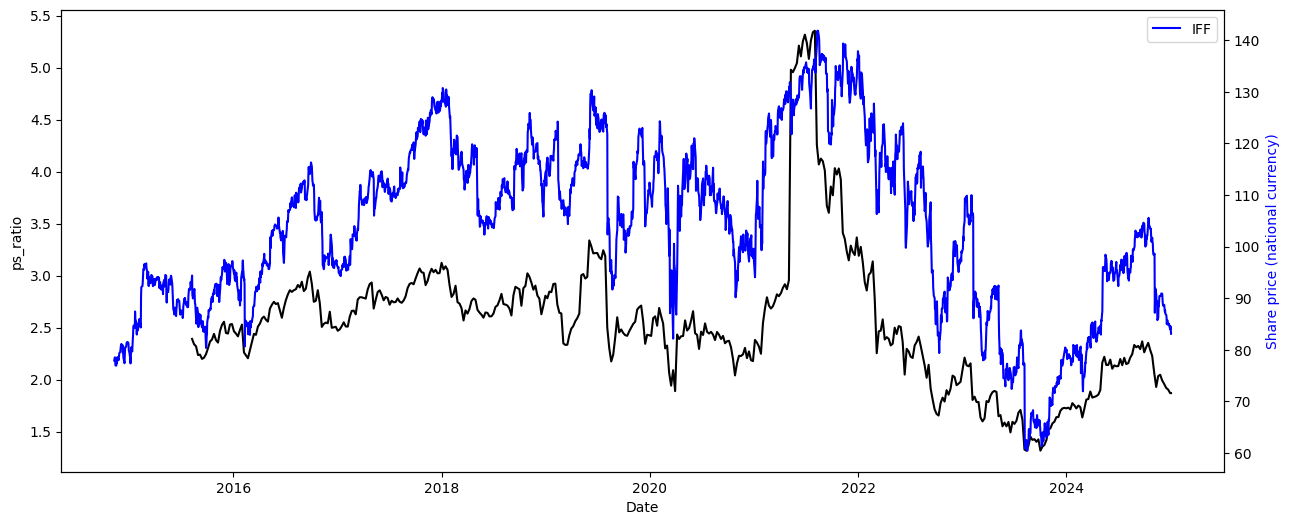

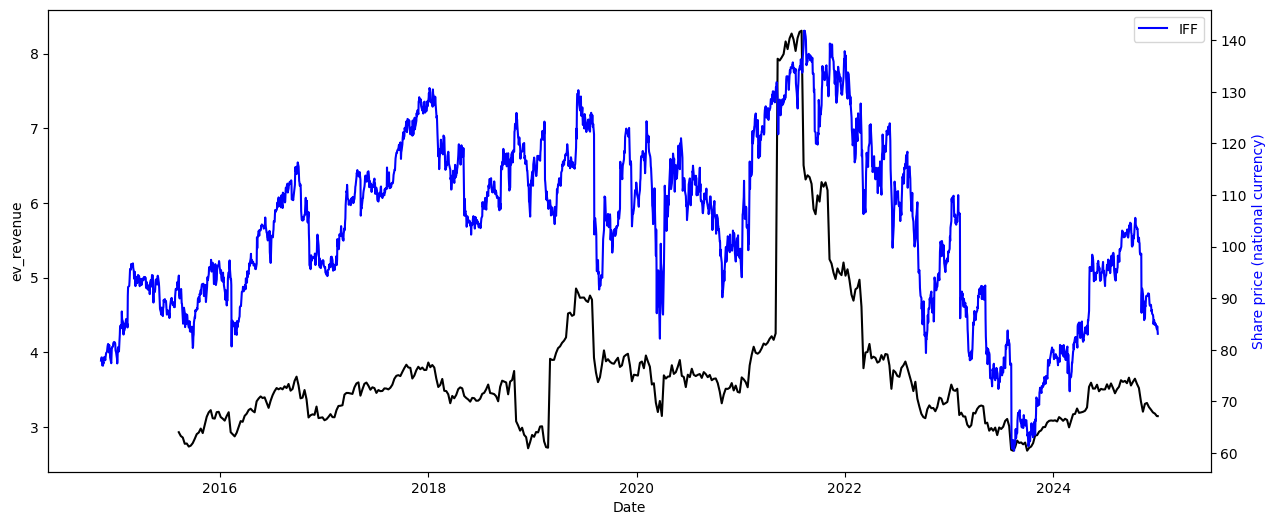

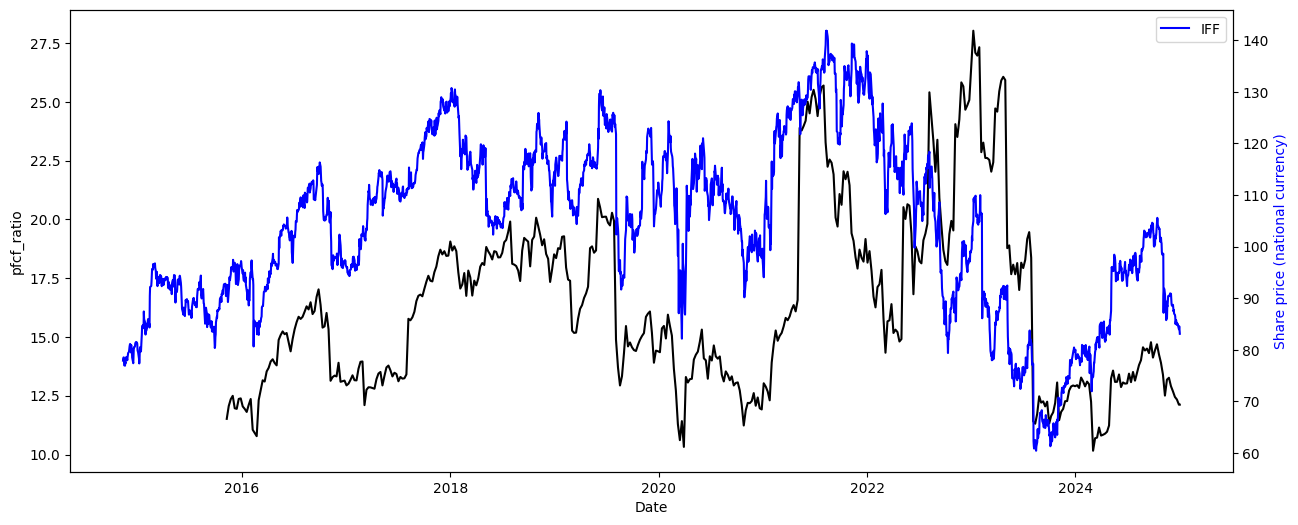

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

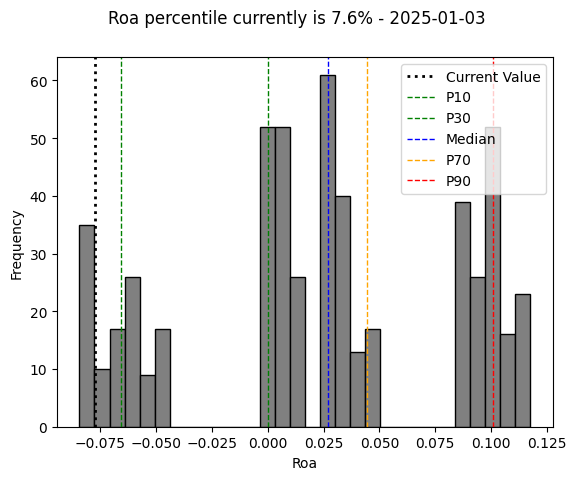

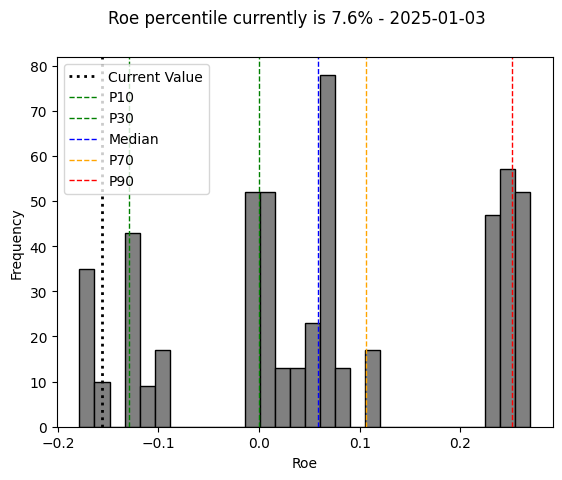

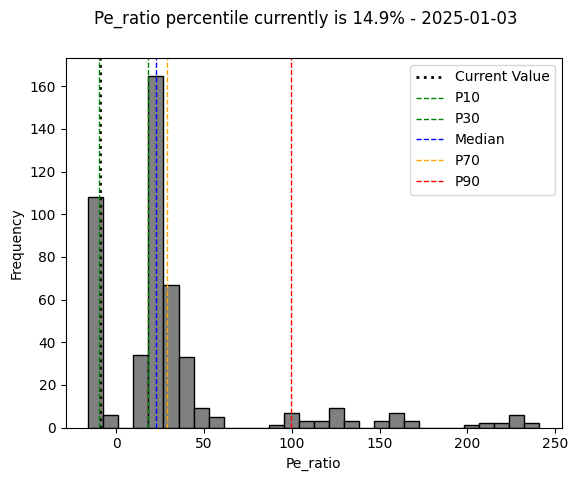

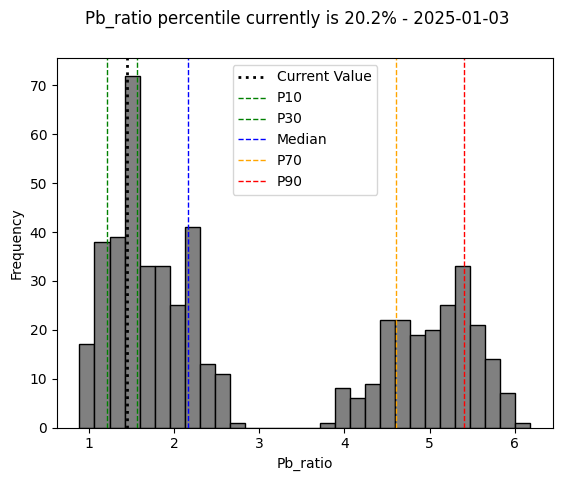

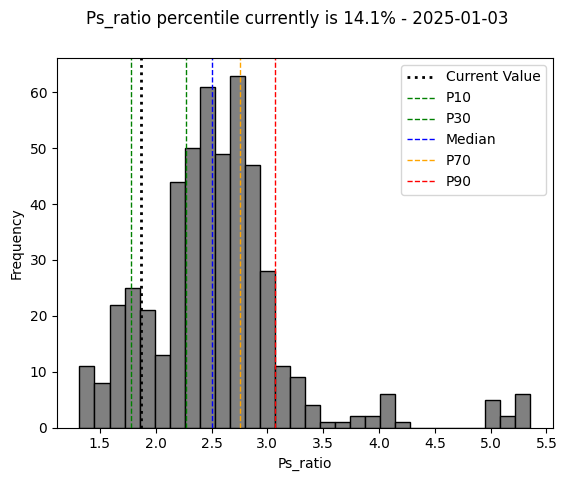

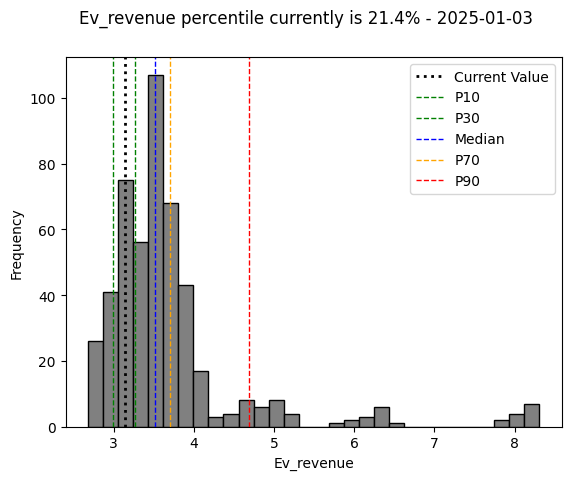

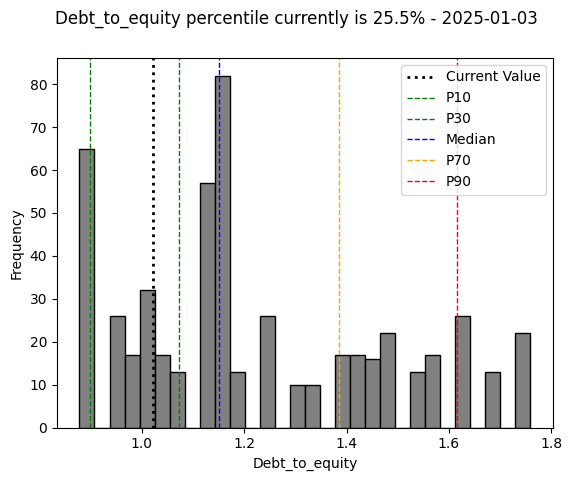

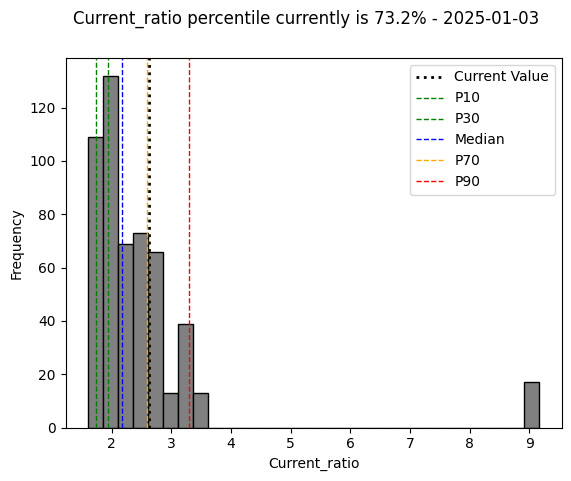

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995580,0.118704,0.724134,0.360605,-0.053563,0.683495,0.160008
roe,0.995580,1.000000,0.078967,0.753859,0.340146,-0.084160,0.725656,0.150590
pe_ratio,0.118704,0.078967,1.000000,-0.150791,0.773318,0.844306,-0.317017,-0.049202
pb_ratio,0.724134,0.753859,-0.150791,1.000000,0.247120,-0.212836,0.898928,0.166570
ps_ratio,0.360605,0.340146,0.773318,0.247120,1.000000,0.856431,0.124443,0.119915
ev_revenue,-0.053563,-0.084160,0.844306,-0.212836,0.856431,1.000000,-0.335852,-0.184523
debt_to_equity,0.683495,0.725656,-0.317017,0.898928,0.124443,-0.335852,1.000000,0.247392
current_ratio,0.160008,0.150590,-0.049202,0.166570,0.119915,-0.184523,0.247392,1.000000


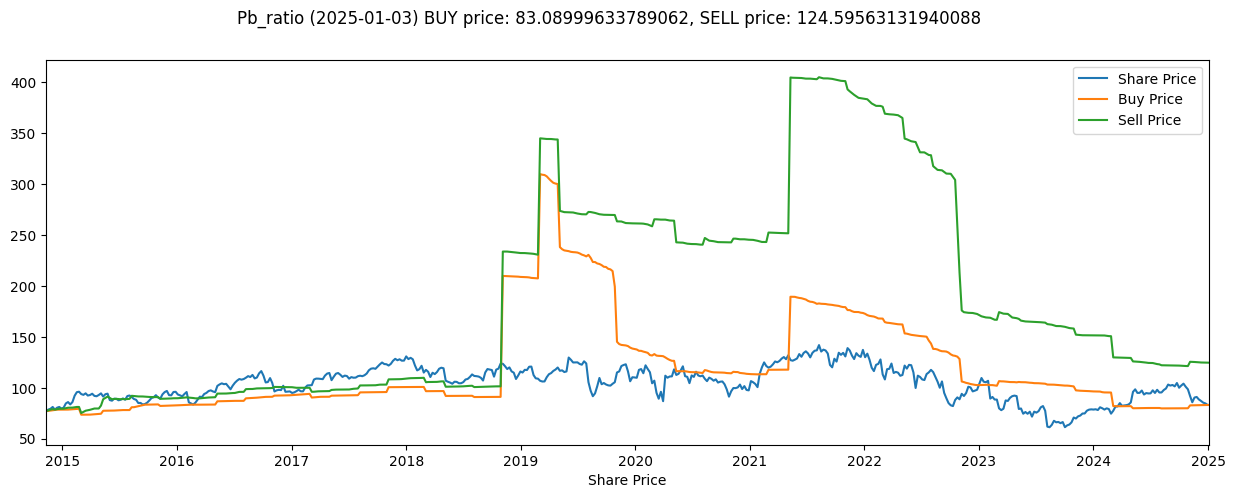

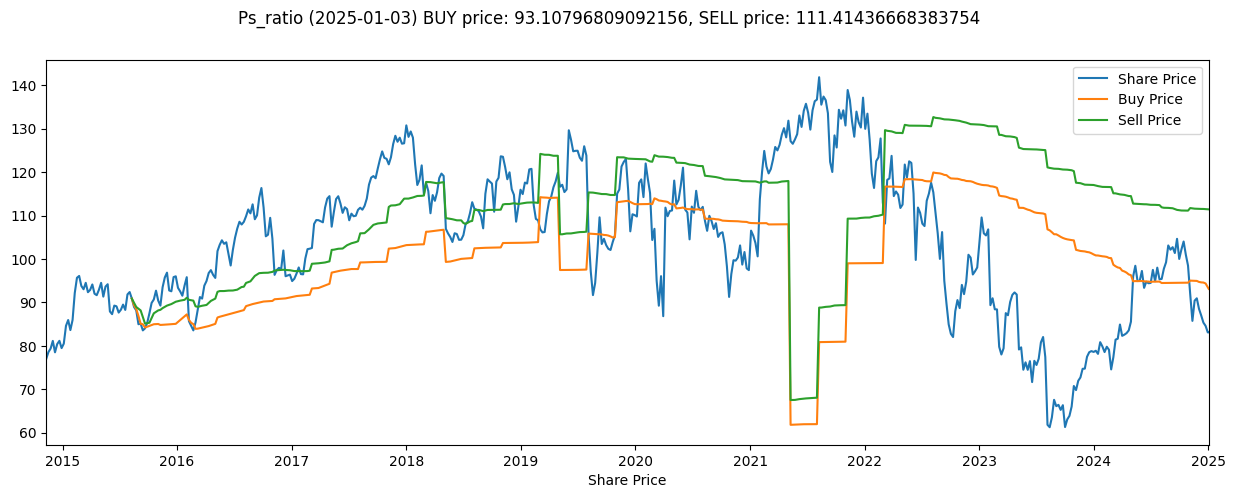

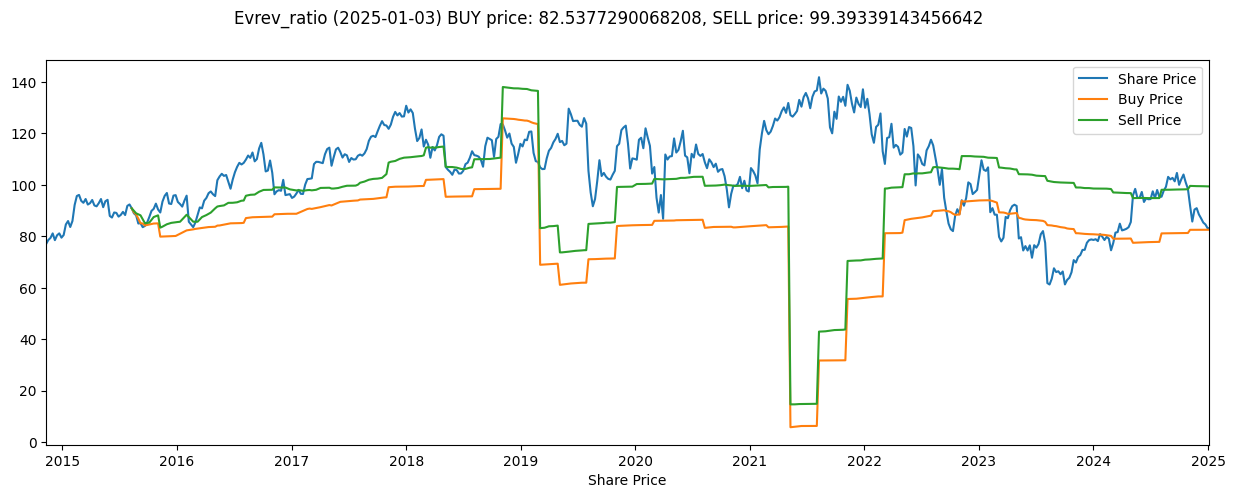

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)